In [1]:
!pip install ../../OSAR-keras/.

Processing /mnt/c/Users/ustyu/OneDrive/Projects/OSAR-keras
  Preparing metadata (setup.py) ... done
  Created wheel for OSAR-nightly: filename=OSAR_nightly-0.1.20.dev20220414-cp39-cp39-linux_x86_64.whl size=80480 sha256=c678cd5615f8286d04ae264496e569e3a11c123871cf5405b83326c8574e3464
  Stored in directory: /home/constantine/.cache/pip/wheels/b0/55/4a/1bb4852a26744ba9735d506993c618d1ab7be56275314d8ea7
Successfully built OSAR-nightly
  Attempting uninstall: OSAR-nightly
    Found existing installation: OSAR-nightly 0.1.20.dev20220414
    Uninstalling OSAR-nightly-0.1.20.dev20220414:
      Successfully uninstalled OSAR-nightly-0.1.20.dev20220414


In [2]:
from __future__ import absolute_import, division, print_function

import os
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tempfile
import reverb

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()
from OSAR import OSARActorDistributionNetwork

print(tf.version.VERSION)

2.7.0


2022-04-14 14:06:06.281546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-14 14:06:06.352280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-14 14:06:06.352749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-14 14:06:06.355140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Setup

## Hyperparameters

In [4]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

batch_size = 16 # @param {type:"integer"}

memory_len = 5 # @param {type: "integer"}
n_turns = 3 # @param {type: "integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (32, 16)
critic_joint_fc_layer_params = (32, 16)

log_interval = 100 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

policy_save_interval = 1000 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using suites. We have different suites for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let's load the Minituar environment from the Pybullet suite.

pybullet build time: Oct 11 2021 21:00:24


current_dir=/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/pybullet_envs/bullet
urdf_root=/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/pybullet_data
argv[0]=
argv[0]=


/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


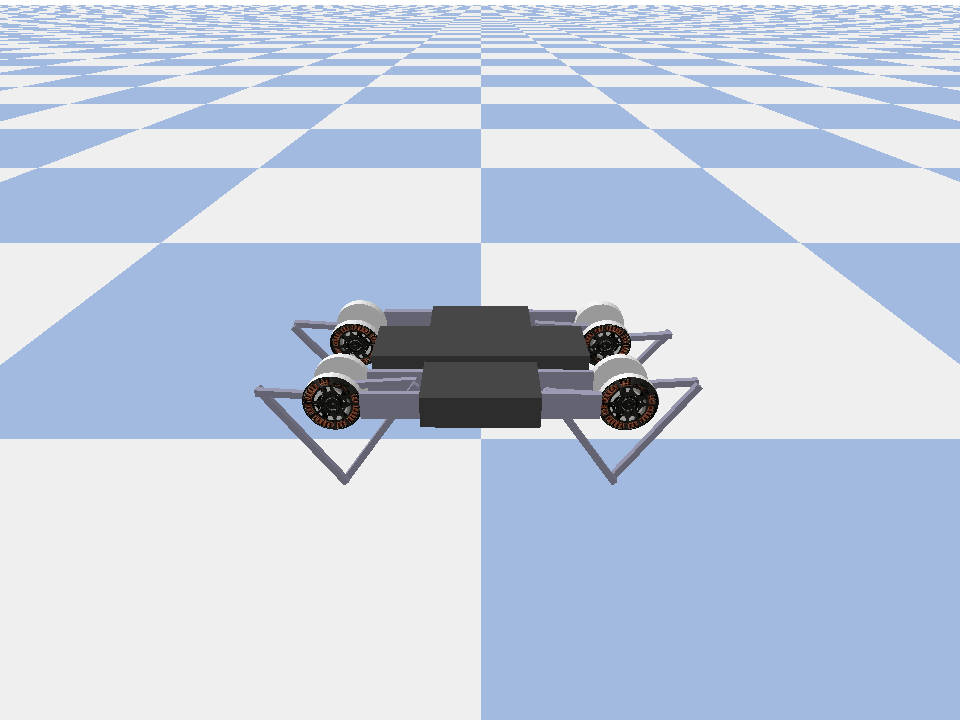

In [5]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will control the Minitaur robot and have it move forward as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode. Observation and action specs of this environment are following:

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


The observation is fairly complex. We receive 28 values representing the angles, velocities, and torques for all the motors. In return the environment expects 8 values for the actions between [-1, 1]. These are the desired motor angles.

In [7]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/pybullet_data
argv[0]=
argv[0]=
urdf_root=/home/constantine/miniconda3/envs/agents/lib/python3.9/site-packages/pybullet_data
argv[0]=
argv[0]=


## Distribution Strategy

In [8]:
use_gpu = False

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

## Agent

The critic will give us value estimates for Q(s,a). That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.

In [9]:
observation_spec, action_spec, time_step_spec = (
    spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork(
          (observation_spec, action_spec),
          observation_fc_layer_params=None,
          action_fc_layer_params=None,
          joint_fc_layer_params=critic_joint_fc_layer_params,
          kernel_initializer='glorot_normal',
          last_kernel_initializer='glorot_normal')

We will use this critic to train an actor network which will allow us to generate actions given an observation.

# Context Generator Demo

The ActorNetwork will predict parameters for a tanh-squashed MultivariateNormalDiag distribution. This distribution will then be sampled, conditioned on the current observation, whenever we need to generate actions.

In [10]:
from OSAR import OSARActorDistributionNetwork
from OSAR.policy import ActorRewardPolicy

with strategy.scope():
    # actor_net = TestActor(
    #     observation_spec,
    #     action_spec,
    #     fc_layer_params=actor_fc_layer_params,
    #     continuous_projection_net=(
    #         tanh_normal_projection_network.TanhNormalProjectionNetwork))
    actor_net = OSARActorDistributionNetwork(
        observation_spec,
        action_spec,
        memory_len=memory_len,
        n_turns=n_turns,
        fc_layer_params=actor_fc_layer_params,
        )

With these networks at hand we can now instantiate the agent.

In [11]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        actor_policy_ctor=ActorRewardPolicy,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

2022-04-14 14:06:10.221607: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-14 14:06:12.009897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-04-14 14:06:13.917431: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Instructions for updating:
Do not call `graph_parents`.


## Replay buffer

In [12]:
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

In [13]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmp5qwop246.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmp5qwop246
[reverb/cc/platform/default/server.cc:71] Started replay server on port 19884


In [14]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [15]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

## Policies

In [16]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [17]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [18]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

## Actors

In [19]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [20]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [21]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

In [22]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

## Learners

In [23]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  strategy=strategy)

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-04-14 14:06:22.296970: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


## Metrics and Evaluation

In [24]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [25]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -1.963542, AverageEpisodeLength = 735.200012


## Training the agent

In [26]:
try:
    %%time
except:
    pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

[reverb/cc/client.cc:163] Sampler and server are owned by the same process (4450) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (4450) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (4450) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (4450) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (4450) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 19.098344802856445
step = 200: loss = 10.494516372680664
step = 300: loss = 5.166970729827881
step = 400: loss = -4.036005973815918
step = 500: loss = -2.968822956085205
step = 600: loss = -4.96513557434082
step = 700: loss = -7.966313362121582
step = 800: loss = -4.320165634155273
step = 900: loss = -6.783553600311279
step = 1000: AverageReturn = -0.893344, AverageEpisodeLength = 706.750000
step = 1000: loss = -1.0453004837036133
step = 1100: loss = -15.118014335632324
step = 1200: loss = -9.515281677246094
step = 1300: loss = -7.924914360046387
step = 1400: loss = -19.04647445678711
step = 1500: loss = -17.45444107055664
step = 1600: loss = -19.199676513671875
step = 1700: loss = -16.278446197509766
step = 1800: loss = -22.83987808227539
step = 1900: loss = -20.806137084960938
step = 2000: AverageReturn = -1.261213, AverageEpisodeLength = 682.799988
step = 2000: loss = -24.200393676757812
step = 2100: loss = -25.93594741821289
step = 2200: loss = -27.6793212890625


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


## Visualization

(-1.7206094302237034, 0.16917641833424568)

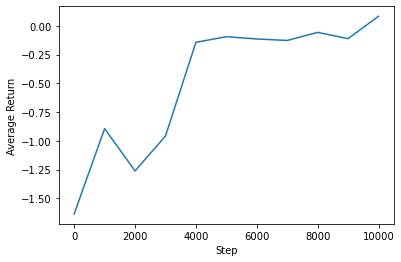

In [27]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [28]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [29]:
num_episodes = 3
video_filename = 'sac_cc_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)